# ВКРБ на тему: “Построение бинарных классификаторов с использованием спектральных преобразований и вейвлет-анализа”

Исходный датасет представляет собой совокупность числовых записей, каждая из которых соответствует одному пациенту и содержит 24 информационных признака. Каждый признак представляет собой коэффициент разложения усреднённой амплитудно-частотной характеристики (АЧХ) пациента в ряд Фурье. Данные АЧХ регистрировались с использованием специализированного медицинского оборудования, отражающего реакцию сосудистой системы организма на внешнее воздействие в зависимости от частоты сигнала. Для минимизации влияния случайных шумов и повышения репрезентативности исходные измерения подвергались процедуре усреднения по временному интервалу наблюдения.

В результате дискретного преобразования Фурье временных зависимостей АЧХ каждого пациента был получен компактный спектральный портрет сигнала, представленный первыми 24 гармониками. Эти коэффициенты несут основную информацию о форме исходного сигнала и могут содержать как низкочастотные тренды, так и высокочастотные особенности, потенциально значимые для последующей классификации.

Целевая переменная датасета указывает на наличие либо отсутствие у пациента аневризмы брюшной аорты и принимает бинарное значение:

0 — пациент здоров;  
1 — у пациента диагностирована аневризма брюшной аорты.  

Таким образом, формируемый датасет состоит из 24 числовых признаков, описывающих спектральные характеристики АЧХ, и одной целевой бинарной метки, что делает его пригодным для решения задачи бинарной классификации с применением методов машинного обучения. 



In [2]:
import pandas as pd

# Укажите путь к файлу
file_path = '../АЧХ Периферии + 1 здоровый пациент.xlsx'

# Загрузка файла
data = pd.read_excel(file_path)

# Убираем ненужные столбцы
data = data.iloc[:, 2:-2]

# Добавляем метки классов (1 - патология, 0 - здоровы)
data['class'] = [1] * 48 + [0] * 27


# Делим данные на признаки и целевую переменную
X = data.drop(columns=['class'])
y = data['class']

# Просмотр первых строк
print(data)

            1         2         3         4         5         6         7  \
0   15.207138  9.644224  2.385555  0.716226  0.443322  0.077719  0.017524   
1   15.715831  8.247748  4.719993  1.686942  1.503716  1.514339  0.823519   
2   17.410188  7.939781  4.498616  1.409610  1.215570  1.567751  0.753980   
3   15.364846  7.826511  5.141236  1.502591  1.536018  1.797533  0.834646   
4   14.215492  7.990558  5.221644  1.527849  1.051440  1.719364  0.862742   
..        ...       ...       ...       ...       ...       ...       ...   
70  15.290936  8.578419  5.055918  2.457683  1.527500  2.664049  2.297752   
71   9.735415  8.582050  6.647016  4.651780  2.631093  1.376579  0.901718   
72   9.925955  7.683149  6.811880  4.232480  2.136721  1.164705  1.309393   
73  15.347328  8.789698  4.597750  1.882121  0.776678  0.513967  0.406415   
74  17.344928  7.483552  4.289682  1.941669  1.300625  0.919230  0.934130   

           8         9        10  ...        16        17        18        

После получения датасета следующим этапом стало исследование применимости методов машинного обучения к задаче автоматической диагностики наличия аневризмы брюшной аорты на основе полученных коэффициентов Фурье. 

На данном этапе я намеренно минимизировал предварительную обработку данных, чтобы понять, насколько эффективно можно использовать сырые данные без глубокого анализа и оптимизации признакового пространства. Это позволило оценить потенциал используемых моделей машинного обучения "в чистом виде" и получить базовый уровень качества классификации.  

Было протестировано 10 различных алгоритмов машинного обучения. Для всех моделей была проведена кросс-валидация с 5 фолдами (StratifiedKFold), чтобы обеспечить надёжную оценку их производительности на ограниченном объеме данных. Результаты оценки моделей были визуализированы в виде четырех горизонтальных столбчатых диаграмм (рисунки 7–10), каждая из которых отображает сравнение одной из указанных метрик между всеми моделями.


In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier  # Ансамблевые методы
from sklearn.linear_model import LogisticRegression  # Логистическая регрессия
from sklearn.svm import SVC  # Метод опорных векторов
from sklearn.tree import DecisionTreeClassifier  # Дерево решений
from sklearn.neighbors import KNeighborsClassifier  # Метод ближайших соседей
from sklearn.naive_bayes import GaussianNB  # Наивный Байес
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis  # Линейный и квадратичный дискриминантный анализ
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# random_seed = random.randint(1, 1000)
random_seed = 1
print(f'Сид генерации: {random_seed}')

# Словарь классификаторов
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=random_seed),
    "Support Vector Machine (SVM)": SVC(random_state=random_seed),
    "Decision Tree": DecisionTreeClassifier(random_state=random_seed),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(reg_param=0.15),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed),
    "AdaBoost": AdaBoostClassifier(random_state=random_seed),
}

# Исходные данные
X_temp = X  # Убедись, что X и y определены

# Инициализация StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Список для хранения результатов всех классификаторов
results_summary = []

# Цикл по каждому классификатору
for clf_name, model in classifiers.items():
    print(f"Обучение модели: {clf_name}")
    
    all_y_true = []
    all_y_pred = []

    # Кросс-валидация
    for fold, (train_index, test_index) in enumerate(skf.split(X_temp, y), start=1):
        X_train, X_test = X_temp.iloc[train_index], X_temp.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    # Получаем общие метрики
    report = classification_report(all_y_true, all_y_pred, output_dict=True, target_names=['Class 0', 'Class 1'])

    accuracy = report['accuracy']
    macro_precision = report['macro avg']['precision']
    macro_recall = report['macro avg']['recall']
    macro_f1 = report['macro avg']['f1-score']

    # Сохраняем в сводку
    results_summary.append({
        "Classifier": clf_name,
        "Accuracy": accuracy,
        "Macro Precision": macro_precision,
        "Macro Recall": macro_recall,
        "Macro F1-Score": macro_f1
    })

    # Записываем в файл
    with open(f"cross_validation_reports/{clf_name}.txt", "w") as f:
        f.write(classification_report(all_y_true, all_y_pred, target_names=['Class 0', 'Class 1']))

# Преобразуем в DataFrame и сортируем по accuracy
results_df = pd.DataFrame(results_summary).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

# Вывод таблицы в консоль
print("\nРезультаты классификаторов (отсортировано по Accuracy):")
print(results_df.to_string(index=False))

Сид генерации: 1
Обучение модели: Random Forest
Обучение модели: Logistic Regression
Обучение модели: Support Vector Machine (SVM)
Обучение модели: Decision Tree
Обучение модели: K-Nearest Neighbors
Обучение модели: Naive Bayes
Обучение модели: Linear Discriminant Analysis
Обучение модели: Quadratic Discriminant Analysis
Обучение модели: Gradient Boosting
Обучение модели: AdaBoost

Результаты классификаторов (отсортировано по Accuracy):
                     Classifier  Accuracy  Macro Precision  Macro Recall  Macro F1-Score
                  Random Forest  0.720000         0.708157      0.651620        0.657683
              Gradient Boosting  0.706667         0.679894      0.657407        0.662990
                    Naive Bayes  0.693333         0.682540      0.606481        0.601525
                  Decision Tree  0.693333         0.664216      0.655093        0.658348
   Linear Discriminant Analysis  0.680000         0.646825      0.628472        0.632353
                       Ad

Для обеспечения модульности, повторного использования кода и удобства сопровождения проекта основные функции обработки данных, машинного обучения и визуализации были вынесены в отдельные модули в виде пакетов Python (`data_transformations.py`, `model_evaluation.py`, `visualization.py`). Такая архитектура позволяет отделить логику преобразования данных от процесса обучения моделей и упрощает проведение экспериментов с различными параметрами и методами.

Приведённый ниже код добавляет корневую директорию проекта в список путей для поиска модулей, чтобы ноутбук мог корректно импортировать функции из соседних каталогов. Это делает структуру проекта более гибкой и пригодной для масштабирования.

In [7]:
import sys
import os

# Добавляем путь к корню проекта
sys.path.append(os.path.abspath(os.path.join('..')))


Для повышения качества классификации и выявления наиболее значимых признаков в работе был реализован модуль, позволяющий проводить систематический анализ эффективности различных срезов данных на основе метрики accuracy. Данный этап исследования стал ключевым для формирования информативного признакового пространства, так как позволил оценить, какие именно фрагменты сигнала (наборы коэффициентов Фурье) несут наибольшую диагностическую ценность.

Особое внимание было уделено поиску зависимости между началом или концом АЧХ и способностью модели корректно классифицировать пациентов . Было протестировано множество комбинаций, включая:

- использование первых N столбцов и проверка всех срезов,  
- использование последних N столбцов и проверка всех срезов,  
- применение дополнительных преобразований: Фурье и вейвлет-преобразований.  

Целью данного блока кода является полный перебор всех возможных начальных позиций срезов и их длин , с последующей оценкой точности выбранных моделей машинного обучения. Такой подход позволяет:  

- выявить наиболее информативные области сигнала;  
- обосновать выбор конкретного диапазона для дальнейших экспериментов;  
- оценить влияние применения математических преобразований (в том числе вейвлет-разложения) на качество классификации.  

Таким образом, результаты работы этого модуля легли в основу дальнейшей оптимизации метода диагностики аневризмы аорты — в частности, при выборе оптимального вейвлета, уровня разложения и финальной настройке моделей машинного обучения.

In [3]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from utils.model_evaluation import evaluate_model_on_slices

def apply_transform(X, transform_func, **kwargs):
    """
    Применяет преобразование к данным.
    
    Параметры:
        X: DataFrame с признаками.
        transform_func: Функция преобразования данных (например, apply_wavelet_transform).
                         Если None, данные не преобразуются.
        kwargs: Дополнительные параметры для функции преобразования.
    
    Возвращает:
        Преобразованные данные.
    """
    if transform_func is not None:
        return transform_func(X, **kwargs)
    return X.copy()

def process_slice(i, X, y, model, transform_func, transform_params):
    """
    Обрабатывает один срез данных с возможностью применения преобразования.
    
    Параметры:
        i: Индекс начального столбца среза.
        X: DataFrame с признаками.
        y: Series с целевой переменной.
        model: Экземпляр модели (например, RandomForestClassifier).
        transform_func: Функция преобразования данных (например, apply_wavelet_transform).
        transform_params: Словарь с параметрами для функции преобразования.
    
    Возвращает:
        Список результатов для данного среза.
    """
    X_temp = X.iloc[:, i:]  # Берем срез данных, начиная с i-го столбца
    
    # Применяем преобразование
    X_temp = apply_transform(X_temp, transform_func, **transform_params)
    
    # Оцениваем модель на срезах данных
    temp_results = evaluate_model_on_slices(
        X_temp, y, slice_sizes=[j for j in range(1, X_temp.shape[1] + 1)], model=model
    )
    
    # Формируем результаты с информацией о срезе
    results_for_slice = []
    for key, value in temp_results.items():
        results_for_slice.append({
            "slice_start": i,  # Индекс начального столбца среза
            "slice_type": key,  # Тип среза (например, "First 5" или "Last 5")
            "accuracy": value,  # Средняя точность
            "transform_name": f"{transform_func.__name__}({transform_params})" if transform_func else "None",  # Имя преобразования
            "model_name": type(model).__name__  # Имя модели
        })
    
    return results_for_slice

def analyze_model_with_transforms_parallel(
    X, y, models, transform_funcs, n_jobs=-1, random_seed=42
):
    """
    Анализирует работу моделей на различных срезах данных с применением преобразований.
    Выполняет параллельную обработку для каждого преобразования и сразу выводит результаты.
    
    Параметры:
        X: DataFrame с признаками.
        y: Series с целевой переменной.
        models: Список экземпляров моделей (например, [SVC(), RandomForestClassifier()]).
        transform_funcs: Список кортежей, где каждый кортеж содержит функцию преобразования и её параметры.
                         Например: [(apply_wavelet_transform, {"wavelet": "db1"}), ...].
        n_jobs: Количество потоков для параллельного выполнения (по умолчанию -1, что означает использование всех доступных ядер).
        random_seed: Значение для random_state (по умолчанию 42).
    
    Возвращает:
        all_results: Список всех результатов, отсортированных по точности в обратном порядке.
    """
    # Инициализация структуры для хранения всех результатов
    all_results = []
    
    # Последовательная обработка для каждой модели и каждого преобразования
    for model in models:
        print(f"\nРезультаты для модели {type(model).__name__}:")
        
        for transform_func, transform_params in transform_funcs:
            # Генерация задач для текущего преобразования
            tasks = [
                (i, X, y, model, transform_func, transform_params)
                for i in range(X.shape[1])
            ]
            
            # Параллельная обработка задач для текущего преобразования
            results_list = Parallel(n_jobs=n_jobs)(
                delayed(process_slice)(*task)
                for task in tasks
            )
            
            # Объединение результатов для текущего преобразования
            results_for_transform = []
            for result in results_list:
                results_for_transform.extend(result)
            
            # Сортировка результатов для текущего преобразования
            results_for_transform.sort(key=lambda x: x["accuracy"], reverse=True)
            
            # Сохранение результатов
            all_results.extend(results_for_transform)
            
            # Вывод результатов для текущего преобразования
            transform_name = f"{transform_func.__name__}({transform_params})" if transform_func else "None"
            print(f"\n  Преобразование: {transform_name}")
            for result in results_for_transform[:5]:  # Выводим топ-5 результатов для текущего преобразования
                print(
                    f"    Срез: {result['slice_start']}, "
                    f"Тип: {result['slice_type']}, "
                    f"Accuracy: {result['accuracy']:.4f}"
                )
    
    # Сортировка всех результатов по точности
    all_results.sort(key=lambda x: x["accuracy"], reverse=True)
    
    return all_results

На данном этапе исследования проводится систематический анализ эффективности различных подходов к представлению сигнала на основе спектральных и вейвлет-преобразований. 

Для этого реализован параллельный перебор всех возможных начальных позиций срезов данных (например, столбцы 1–5, 2–6 и т.д.), а также применение следующих преобразований:

- исходные данные без преобразования
- дополнительное преобразование Фурье
- вейвлет-преобразование

Этот этап позволяет:
- оценить, какие комбинации признаков и преобразований обеспечивают максимальную точность классификации,
- определить наиболее информативные области сигнала для дальнейшей работы.

---

Для анализа были выбраны две модели машинного обучения:  
`SVC()` и `RandomForestClassifier()`.

Этот выбор обусловлен их противоположными поведениями на предыдущих этапах исследования:

RandomForestClassifier:
- Показал наибольшую точность и устойчивость среди всех протестированных моделей.
- Устойчив к переобучению, не требует масштабирования, позволяет оценивать важность признаков.
- Применяется как эталонная модель, демонстрирующая стабильные результаты и помогающая выявить общие закономерности в данных.

SVC (Support Vector Classifier):
- Изначально демонстрировал нулевую точность (null accuracy) — предсказывала только один класс ("все больны").
- Высокочувствителен к масштабу признаков и качеству представления данных.
- Рассматривается как экспериментальная модель, которую можно "вытянуть" до уровня других алгоритмов за счёт правильно подобранных признаков и преобразований.

---

Выбор этих двух моделей позволяет:
- оценить влияние преобразований на уже хорошо работающую модель (`RandomForestClassifier`),
- проверить гипотезу о возможности значительного улучшения производительности слабой модели (`SVC`) через корректную предобработку данных.

Результаты данного анализа легли в основу дальнейших экспериментов по:
- выбору оптимального вейвлета,
- формированию финального признакового пространства,
- итоговой настройке моделей и сравнению их эффективности.

In [93]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from utils.data_transformations import apply_fourier_transform, apply_wavelet_transform
import pywt

# Определение моделей
models = [SVC(), RandomForestClassifier()]

# Определение преобразований
transform_funcs = [(None, {}), (apply_fourier_transform, {}), (apply_wavelet_transform, {})]

# Анализ моделей с преобразованиями
all_results = analyze_model_with_transforms_parallel(
    X, y, models=models, transform_funcs=transform_funcs, n_jobs=-1
)


Результаты для модели SVC:

  Преобразование: None
    Срез: 0, Тип: Last 1, Accuracy: 0.7200
    Срез: 0, Тип: Last 2, Accuracy: 0.7200
    Срез: 0, Тип: Last 3, Accuracy: 0.7200
    Срез: 1, Тип: Last 1, Accuracy: 0.7200
    Срез: 1, Тип: Last 2, Accuracy: 0.7200

  Преобразование: apply_fourier_transform({})
    Срез: 22, Тип: Last 1, Accuracy: 0.8000
    Срез: 1, Тип: First 1, Accuracy: 0.7200
    Срез: 14, Тип: Last 3, Accuracy: 0.7200
    Срез: 15, Тип: Last 4, Accuracy: 0.7200
    Срез: 15, Тип: Last 5, Accuracy: 0.7200

  Преобразование: apply_wavelet_transform({})
    Срез: 0, Тип: Last 1, Accuracy: 0.7733
    Срез: 2, Тип: Last 1, Accuracy: 0.7733
    Срез: 4, Тип: Last 1, Accuracy: 0.7733
    Срез: 6, Тип: Last 1, Accuracy: 0.7733
    Срез: 8, Тип: Last 1, Accuracy: 0.7733

Результаты для модели RandomForestClassifier:

  Преобразование: None
    Срез: 20, Тип: First 1, Accuracy: 0.7600
    Срез: 20, Тип: First 3, Accuracy: 0.7600
    Срез: 11, Тип: First 12, Accuracy: 0.74

После получения хороших результатов с использованием базового вейвлета `db1`, возникла задача дальнейшей оптимизации подхода к обработке данных. Для этого было принято решение провести полный перебор всех доступных дискретных вейвлетов из библиотеки `PyWavelets`, чтобы выявить тот, который обеспечивает наибольшую информативность признаков, полученных в результате преобразования.

Цель этапа:
- найти наиболее эффективный тип вейвлета для анализа амплитудно-частотных характеристик (АЧХ) пациентов;
- повысить качество классификации моделей `RandomForestClassifier` и `SVC`;
- исследовать влияние формы базисной функции на структуру признакового пространства.

Почему важен выбор вейвлета?

Разные семейства вейвлетов обладают различными свойствами:  
- симметрия / асимметрия,  
- количество моментов,  
- гладкость,  
- временная и частотная локализация.

Эти особенности влияют на то, какой информацией будут заполнены коэффициенты аппроксимации и детализации, а значит — и на эффективность последующих моделей машинного обучения. Например:
- Вейвлеты `Daubechies` обеспечивают хорошее частотное разрешение;
- `Symlets` отличаются улучшенной симметрией, что полезно для медицинских сигналов;
- `Coiflets` хорошо подходят для гладких сигналов;
- `Biorthogonal` часто применяются в задачах восстановления сигнала.

Поэтому выбор правильного вейвлета становится ключевым шагом в повышении качества классификации.

---

Как работает анализ?

Для каждого протестированного вейвлета выполнялся следующий процесс:
1. Применялось вейвлет-преобразование к различным диапазонам исходных данных (например, столбцы 18–24);
2. Формировался набор новых признаков — как полное разложение, так и отдельные компоненты;
3. Обучались две модели: `RandomForestClassifier` и `SVC`;
4. Оценивалось качество классификации по метрике `accuracy`.

Такой подход позволил не просто формально применять преобразование, но и находить такие сочетания вейвлета и входных данных, которые дают максимальную эффективность для решения задачи диагностики аневризмы брюшной аорты.

In [19]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from utils.data_transformations import apply_wavelet_transform
import pywt

# Определение моделей
models = [SVC(), RandomForestClassifier()]

# Определение преобразований
transform_funcs = [(apply_wavelet_transform, {"wavelet": wavelet_name}) for wavelet_name in pywt.wavelist(kind='discrete')]

# Анализ моделей с преобразованиями
all_results = analyze_model_with_transforms_parallel(
    X, y, models=models, transform_funcs=transform_funcs, n_jobs=-1
)

from pprint import pprint

with open('all_results.txt', 'w') as f:
    pprint(all_results, stream=f)


Результаты для модели SVC:

  Преобразование: apply_wavelet_transform({'wavelet': 'bior1.1'})
    Срез: 0, Тип: Last 1, Accuracy: 0.7733
    Срез: 2, Тип: Last 1, Accuracy: 0.7733
    Срез: 4, Тип: Last 1, Accuracy: 0.7733
    Срез: 6, Тип: Last 1, Accuracy: 0.7733
    Срез: 8, Тип: Last 1, Accuracy: 0.7733

  Преобразование: apply_wavelet_transform({'wavelet': 'bior1.3'})
    Срез: 0, Тип: Last 2, Accuracy: 0.7867
    Срез: 2, Тип: Last 2, Accuracy: 0.7867
    Срез: 4, Тип: Last 2, Accuracy: 0.7867
    Срез: 6, Тип: Last 2, Accuracy: 0.7867
    Срез: 8, Тип: Last 2, Accuracy: 0.7867

  Преобразование: apply_wavelet_transform({'wavelet': 'bior1.5'})
    Срез: 0, Тип: Last 3, Accuracy: 0.7733
    Срез: 2, Тип: Last 3, Accuracy: 0.7733
    Срез: 4, Тип: Last 3, Accuracy: 0.7733
    Срез: 6, Тип: Last 3, Accuracy: 0.7733
    Срез: 0, Тип: Last 2, Accuracy: 0.7333

  Преобразование: apply_wavelet_transform({'wavelet': 'bior2.2'})
    Срез: 1, Тип: Last 2, Accuracy: 0.7333
    Срез: 3, Тип

Ниже приведены финальные результаты для двух моделей машинного обучения, показавших наилучшую эффективность при классификации пациентов на основе амплитудно-частотных характеристик, обработанных с использованием вейвлет-преобразования.

| Модель                     | Преобразование                          | Диапазон данных     | Точность (Accuracy) |
|----------------------------|----------------------------------------|---------------------|----------------------|
| `RandomForestClassifier`   | `apply_wavelet_transform({'wavelet': 'db2'})` | Последние 5 столбцов (18–24) | **0.84**             |
| `SVC`                      | `apply_wavelet_transform({'wavelet': 'bior1.3'})` | Последние 2 столбца (23–24)  | **0.787**            |

Эти результаты демонстрируют, что применение вейвлет-преобразований позволяет значительно повысить качество классификации, особенно при выборе информативных диапазонов исходного сигнала и корректном подборе параметров модели.

Визуальное пояснение почему в случае RandomForestClassifier самая лучшая стратегия была - выделение всех столбцов после применения вейвлет-преобразования к срезу 18-24, представлено ниже

Сид генерации: 42


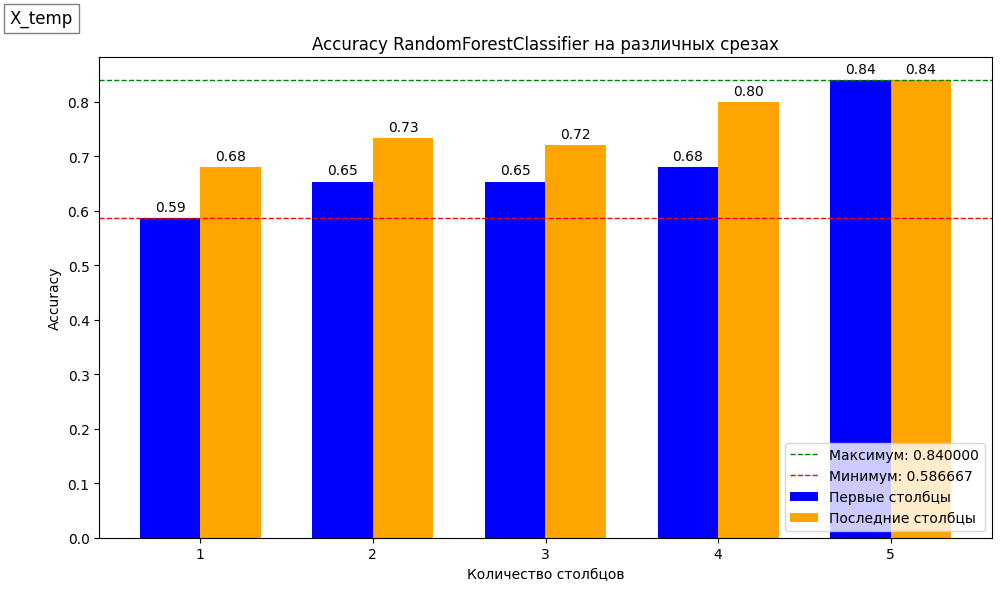

In [ ]:
from utils.visualization import plot_model_results
from utils.data_transformations import apply_wavelet_transform

X_temp = X.iloc[:, 18:]
X_temp = apply_wavelet_transform(X_temp, 'sym2')
X_temp = X_temp.iloc[:, -5:]
plot_model_results(X_temp, y, list(range(1, X_temp.shape[1] + 1)), [RandomForestClassifier()], random_seed=42)

При дальнейшей работе было выявлено, что первая функция покрывала не всевозможные подпоследовательности смежных столбцов и поэтому была реализована модификация для проверки значимости данного упущения.

In [94]:
def process_slice(i, X, y, model, transform_func, transform_params, direction):
    """
    Добавлен параметр direction: 'left_to_right' или 'right_to_left'
    """
    if direction == 'left_to_right':
        X_temp = X.iloc[:, i:]  # Срез слева направо
    elif direction == 'right_to_left':
        X_temp = X.iloc[:, :X.shape[1] - i]  # Срез справа налево
    else:
        raise ValueError("Неверное значение direction")
    
    # Применяем преобразование
    X_temp = apply_transform(X_temp, transform_func, **transform_params)
    
    # Оцениваем модель
    temp_results = evaluate_model_on_slices(
        X_temp, y, 
        slice_sizes=[j for j in range(1, X_temp.shape[1] + 1)], 
        model=model
    )
    
    # Формируем результаты
    results_for_slice = []
    for key, value in temp_results.items():
        results_for_slice.append({
            "slice_start": i,
            "direction": direction,  # Добавляем направление
            "slice_type": key,
            "accuracy": value,
            "transform_name": f"{transform_func.__name__}({transform_params})" if transform_func else "None",
            "model_name": type(model).__name__
        })
    
    return results_for_slice

def analyze_model_with_transforms_parallel(
    X, y, models, transform_funcs, 
    mode='left_to_right',  # Новый параметр
    n_jobs=-1, random_seed=42
):
    """
    Добавлен параметр mode: 'left_to_right', 'right_to_left' или 'full'
    """
    all_results = []
    directions = []
    
    if mode == 'left_to_right':
        directions = ['left_to_right']
    elif mode == 'right_to_left':
        directions = ['right_to_left']
    elif mode == 'full':
        directions = ['left_to_right', 'right_to_left']
    else:
        raise ValueError("mode должен быть 'left_to_right', 'right_to_left' или 'full'")
    
    for model in models:
        print(f"\nРезультаты для модели {type(model).__name__}:")
        
        for transform_func, transform_params in transform_funcs:
            for direction in directions:
                # Генерация задач для текущего направления
                tasks = [
                    (i, X, y, model, transform_func, transform_params, direction)
                    for i in range(X.shape[1])
                ]
                
                # Параллельная обработка
                results_list = Parallel(n_jobs=n_jobs)(
                    delayed(process_slice)(*task)
                    for task in tasks
                )
                
                # Обработка результатов
                results_for_transform = []
                for result in results_list:
                    results_for_transform.extend(result)
                
                # Сохранение и вывод
                all_results.extend(results_for_transform)
                results_for_transform.sort(key=lambda x: x["accuracy"], reverse=True)
                
                transform_name = f"{transform_func.__name__}({transform_params})" if transform_func else "None"
                print(f"\n  Направление: {direction}, Преобразование: {transform_name}")
                for result in results_for_transform[:5]:
                    print(
                        f"    Срез: {result['slice_start']}, "
                        f"Тип: {result['slice_type']}, "
                        f"Accuracy: {result['accuracy']:.4f}"
                    )
    
    all_results.sort(key=lambda x: x["accuracy"], reverse=True)
    return all_results

In [95]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from utils.data_transformations import apply_fourier_transform, apply_wavelet_transform

# Определение моделей
models = [SVC(), RandomForestClassifier()]

# Определение преобразований
transform_funcs = [(None, {}), (apply_fourier_transform, {}), (apply_wavelet_transform, {})]

# Анализ моделей с преобразованиями
all_results = analyze_model_with_transforms_parallel(
    X, y, models=models, transform_funcs=transform_funcs, n_jobs=-1, mode='full'
)


Результаты для модели SVC:

  Направление: left_to_right, Преобразование: None
    Срез: 0, Тип: Last 1, Accuracy: 0.7200
    Срез: 0, Тип: Last 2, Accuracy: 0.7200
    Срез: 0, Тип: Last 3, Accuracy: 0.7200
    Срез: 1, Тип: Last 1, Accuracy: 0.7200
    Срез: 1, Тип: Last 2, Accuracy: 0.7200

  Направление: right_to_left, Преобразование: None
    Срез: 0, Тип: Last 1, Accuracy: 0.7200
    Срез: 0, Тип: Last 2, Accuracy: 0.7200
    Срез: 0, Тип: Last 3, Accuracy: 0.7200
    Срез: 1, Тип: Last 1, Accuracy: 0.7200
    Срез: 1, Тип: Last 2, Accuracy: 0.7067

  Направление: left_to_right, Преобразование: apply_fourier_transform({})
    Срез: 22, Тип: Last 1, Accuracy: 0.8000
    Срез: 1, Тип: First 1, Accuracy: 0.7200
    Срез: 14, Тип: Last 3, Accuracy: 0.7200
    Срез: 15, Тип: Last 4, Accuracy: 0.7200
    Срез: 15, Тип: Last 5, Accuracy: 0.7200

  Направление: right_to_left, Преобразование: apply_fourier_transform({})
    Срез: 4, Тип: First 1, Accuracy: 0.6933
    Срез: 5, Тип: First 

Метрики моделей не были улучшены, но всё равно стоит провести исследование применения различных вейвлетов к новому способу обхода признакового пространства.

In [98]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from utils.data_transformations import apply_wavelet_transform
import pywt

# Определение моделей
models = [SVC(), RandomForestClassifier()]

# Определение преобразований
transform_funcs = [(apply_wavelet_transform, {"wavelet": wavelet_name}) for wavelet_name in pywt.wavelist(kind='discrete')]

# Анализ моделей с преобразованиями
all_results = analyze_model_with_transforms_parallel(
    X, y, models=models, transform_funcs=transform_funcs, n_jobs=-1, mode='right_to_left'
)

from pprint import pprint

with open('all_results_mode=right_to_left.txt', 'w') as f:
    pprint(all_results, stream=f)


Результаты для модели SVC:

  Направление: right_to_left, Преобразование: apply_wavelet_transform({'wavelet': 'bior1.1'})
    Срез: 0, Тип: Last 1, Accuracy: 0.7733
    Срез: 0, Тип: Last 2, Accuracy: 0.7333
    Срез: 0, Тип: Last 3, Accuracy: 0.7333
    Срез: 14, Тип: Last 1, Accuracy: 0.7067
    Срез: 6, Тип: Last 2, Accuracy: 0.6933

  Направление: right_to_left, Преобразование: apply_wavelet_transform({'wavelet': 'bior1.3'})
    Срез: 0, Тип: Last 2, Accuracy: 0.7867
    Срез: 0, Тип: Last 3, Accuracy: 0.7733
    Срез: 0, Тип: Last 1, Accuracy: 0.7733
    Срез: 0, Тип: Last 4, Accuracy: 0.7467
    Срез: 0, Тип: Last 5, Accuracy: 0.7333

  Направление: right_to_left, Преобразование: apply_wavelet_transform({'wavelet': 'bior1.5'})
    Срез: 0, Тип: Last 3, Accuracy: 0.7733
    Срез: 0, Тип: Last 2, Accuracy: 0.7333
    Срез: 0, Тип: Last 4, Accuracy: 0.7333
    Срез: 0, Тип: Last 5, Accuracy: 0.7200
    Срез: 0, Тип: Last 6, Accuracy: 0.7067

  Направление: right_to_left, Преобразов

Также не удалось достичь лучших результатов, так что не будет сильно акцентировать на этом внимание

Демонстрация точности модели на каждом фолде и получение остальных метрик представлено ниже.

In [172]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import random

# Исходные данные
X_temp = X.iloc[:, 18:]
X_temp = apply_wavelet_transform(X_temp, 'db2')
X_temp = X_temp.iloc[:, -5:]

random_seed = random.randint(1, 1000)
print(f'Сид генерации: {random_seed}')
# Инициализация StratifiedKFold для кросс-валидации
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Список для хранения предсказаний и истинных меток
all_y_true = []
all_y_pred = []

# Цикл по разбиениям кросс-валидации
for fold, (train_index, test_index) in enumerate(skf.split(X_temp, y), start=1):
    print(f"Fold {fold}")
    
    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test = X_temp.iloc[train_index], X_temp.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Обучение модели
    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)
    
    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)
    
    # Сохранение истинных меток и предсказаний
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)
    
    # Вывод результатов для текущего фолда
    print("Classification Report for Fold:")
    print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))
    print("True Labels:")
    print(y_test.values)
    print("Predicted Labels:")
    print(y_pred)
    print("-" * 50)

# Генерация отчета classification_report для всех фолдов
report = classification_report(all_y_true, all_y_pred, target_names=['Class 0', 'Class 1'], output_dict=True)

# Вывод общего отчета
print("\nOverall Classification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=['Class 0', 'Class 1']))

# Если нужно, можно преобразовать отчет в DataFrame для дальнейшего анализа
report_df = pd.DataFrame(report).T
print("\nOverall Classification Report as DataFrame:")
print(report_df)

Сид генерации: 169
Fold 1
Classification Report for Fold:
              precision    recall  f1-score   support

     Class 0       0.71      1.00      0.83         5
     Class 1       1.00      0.80      0.89        10

    accuracy                           0.87        15
   macro avg       0.86      0.90      0.86        15
weighted avg       0.90      0.87      0.87        15

True Labels:
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Predicted Labels:
[1 1 1 1 0 1 1 1 1 0 0 0 0 0 0]
--------------------------------------------------
Fold 2
Classification Report for Fold:
              precision    recall  f1-score   support

     Class 0       0.67      0.40      0.50         5
     Class 1       0.75      0.90      0.82        10

    accuracy                           0.73        15
   macro avg       0.71      0.65      0.66        15
weighted avg       0.72      0.73      0.71        15

True Labels:
[1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Predicted Labels:
[1 1 1 1 1 1 1 0 1 1 1 1 0 0 1]
--------

Получено значительное улучшение по сравнению с начальными метриками, так что осталось проверить статистически ли значимые это улучшения или просто стечение обстоятельств.

## Статистическая значимость

In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

X_temp = X.iloc[:, 18:]
X_temp = apply_wavelet_transform(X_temp, 'db2')
X_temp = X_temp.iloc[:, -5:]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(RandomForestClassifier(), X_temp, y, cv=cv, scoring='accuracy')
print(f"Mean Accuracy: {scores.mean():.2f}, Std: {scores.std():.2f}")

Mean Accuracy: 0.81, Std: 0.05


Если стандартное отклонение(std) велико (например, > 0.1), это указывает на нестабильность модели, но в данном случае std не превышает 0.1

### Доверительный интервал

Доверительные интервалы позволяют оценить диапазон, в котором находится истинное значение метрики с заданной вероятностью (например, 95%).

In [31]:
import numpy as np
from scipy.stats import sem, t

confidence_level = 0.95
mean_accuracy = scores.mean()
std_err = sem(scores)  # Стандартная ошибка среднего
margin_of_error = std_err * t.ppf((1 + confidence_level) / 2, len(scores) - 1)

lower_bound = mean_accuracy - margin_of_error
upper_bound = mean_accuracy + margin_of_error

print(f"95% Confidence Interval: ({lower_bound:.2f}, {upper_bound:.2f})")

95% Confidence Interval: (0.74, 0.88)


Если доверительный интервал для accuracy значительно выше Null Accuracy (В нашем случае 0.64), это подтверждает статистическую значимость результата.

In [32]:
import numpy as np
from collections import Counter

def calculate_null_accuracy(y):
    """
    Рассчитывает null accuracy (точность при предсказании самого частого класса).

    Параметры:
    - y: истинные метки классов (например, список или массив)

    Возвращает:
    - null_accuracy: значение null accuracy
    """
    # Подсчет количества объектов каждого класса
    class_counts = Counter(y)
    
    # Нахождение самого частого класса
    most_common_class, most_common_count = class_counts.most_common(1)[0]
    
    # Общее количество объектов
    total_samples = len(y)
    
    # Расчет null accuracy
    null_accuracy = most_common_count / total_samples
    
    return null_accuracy

In [33]:
null_accuracy = calculate_null_accuracy(y)
print(null_accuracy)

0.64


### Размер эффекта

Размер эффекта (effect size) показывает, насколько сильно модель превосходит случайное угадывание. Например, Cohen's d:

In [34]:
d = (mean_accuracy - null_accuracy) / scores.std()
print(f"Cohen's d: {d:.2f}")

Cohen's d: 3.47


d < 0.2: слабый эффект.  
d ≈ 0.5: средний эффект.  
d > 0.8: сильный эффект.  

### Вывод

Средняя точность (accuracy) составила 0.81 с небольшим стандартным отклонением – 0.05, что говорит о стабильной и воспроизводимой работе модели. Был также рассчитан 95% доверительный интервал, который оказался равным (0.74, 0.88), и поскольку он не пересекается точностью на сырых данных (accuracy = 0.72), это однозначно указывает на то, что модель действительно извлекает полезные закономерности из данных, а не просто «угадывает». Кроме того, был рассчитан размер эффекта по Коэну (Cohen’s d), значение которого составило 3.47, что соответствует очень сильному эффекту и подтверждает высокую эффективность подхода. Эти результаты значительно превосходят исходные значения, полученные на сырых данных, где точность RandomForestClassifier составляла всего 0.72.

Далее было решено проверить может ли как-то повлиять выделение главных компонент или приминение сингулярного разложения на повышение точности модели, но положительных результатов это не дало, так что просто ради демострации проделанной работы эта часть была оставлена в коде ВКРБ.

## Сингулярное разложение


In [138]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

# Центрируем данные (без масштабирования!)
X_centered = StandardScaler(with_std=False).fit_transform(X)

svd = TruncatedSVD(n_components=4)
X_svd = svd.fit_transform(X_centered)

In [139]:
svd.explained_variance_ratio_.sum()

np.float64(0.886551578493257)

In [140]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_svd, y, cv=5)
print(f"Accuracy после SVD: {scores.mean():.2f} ± {scores.std():.2f}")

Accuracy после SVD: 0.48 ± 0.11


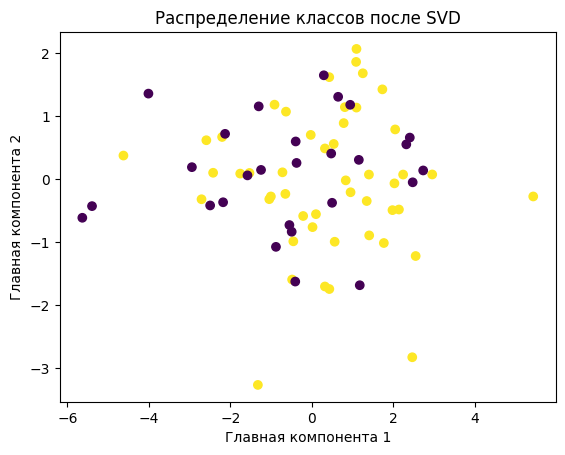

In [145]:
import matplotlib.pyplot as plt

plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y, cmap='viridis')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Распределение классов после SVD')
plt.show()

In [146]:
X_combined = np.hstack([X_svd, X_temp])  # Объединение признаков

scores_combined = cross_val_score(clf, X_combined, y, cv=5)
print(f"Accuracy комбинированной модели: {scores_combined.mean():.2f}")

Accuracy комбинированной модели: 0.76


In [53]:
scores_original = cross_val_score(clf, X_temp, y, cv=5)
scores_cur = cross_val_score(clf, X_svd, y, cv=5)

from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(scores_original, scores_cur)
print(f"p-value: {p_value:.4f}")

p-value: 0.0010


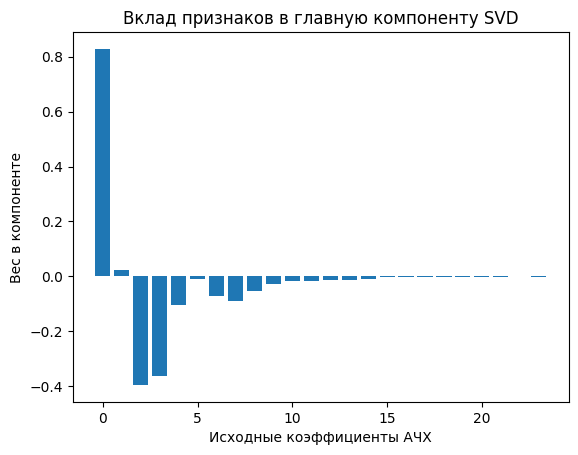

In [54]:
plt.bar(range(X.shape[1]), svd.components_[0])  # Важность признаков для 1-й компоненты
plt.xlabel('Исходные коэффициенты АЧХ')
plt.ylabel('Вес в компоненте')
plt.title('Вклад признаков в главную компоненту SVD')
plt.show()

In [322]:
for n in range(1, 25):
    svd = TruncatedSVD(n_components=n)
    X_svd = svd.fit_transform(X_centered)
    scores = cross_val_score(clf, X_svd, y, cv=5)
    print(f"n_components={n}: {scores.mean():.2f} ± {scores.std():.2f}")

n_components=1: 0.56 ± 0.09
n_components=2: 0.59 ± 0.05
n_components=3: 0.48 ± 0.05
n_components=4: 0.45 ± 0.14
n_components=5: 0.52 ± 0.13
n_components=6: 0.49 ± 0.14
n_components=7: 0.49 ± 0.09
n_components=8: 0.52 ± 0.11
n_components=9: 0.56 ± 0.12
n_components=10: 0.60 ± 0.06
n_components=11: 0.61 ± 0.08
n_components=12: 0.61 ± 0.10
n_components=13: 0.60 ± 0.12
n_components=14: 0.59 ± 0.07
n_components=15: 0.61 ± 0.08
n_components=16: 0.60 ± 0.09
n_components=17: 0.64 ± 0.07
n_components=18: 0.63 ± 0.09
n_components=19: 0.67 ± 0.07
n_components=20: 0.63 ± 0.12
n_components=21: 0.63 ± 0.12
n_components=22: 0.65 ± 0.14
n_components=23: 0.64 ± 0.12
n_components=24: 0.68 ± 0.08


### Ручное вычисление сингулярного разложения

In [79]:
import numpy as np

# Центрируем данные (критично для SVD)
X_centered = X - np.mean(X, axis=0)

# Выполняем SVD
U, Sigma, Vt = np.linalg.svd(X_centered, full_matrices=False)
V = Vt.T  # Правые сингулярные векторы (столбцы V)

$ X_{centered} = U⋅Σ⋅V^T $

In [93]:
k = 3  # Пример: оставляем 2 главные компоненты

# Матрица U_k (n × k) с уменьшенной размерностью
U_k = U[:, :k]

# Матрица Sigma_k (k × k) с топ-k сингулярными значениями
Sigma_k = np.diag(Sigma[:k])

In [137]:
# Проекция данных: X_reduced = U_k * Sigma_k
X_reduced = U_k @ Sigma_k

clf_cur = RandomForestClassifier()
scores= cross_val_score(clf_cur, X_reduced, y, cv=5)
print(f"Accuracy комбинированной модели: {scores.mean():.2f}")

Accuracy комбинированной модели: 0.48


## PCA

In [64]:
from sklearn.decomposition import PCA

# Нормализация данных
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_normalized)

In [65]:
print(f"Объясненная дисперсия PCA: {sum(pca.explained_variance_ratio_):.2f}")

Объясненная дисперсия PCA: 0.85


In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier()
scores = cross_val_score(clf, X_pca, y, cv=5)
print(f"Accuracy после PCA: {scores.mean():.2f} ± {scores.std():.2f}")

Accuracy после PCA: 0.64 ± 0.05


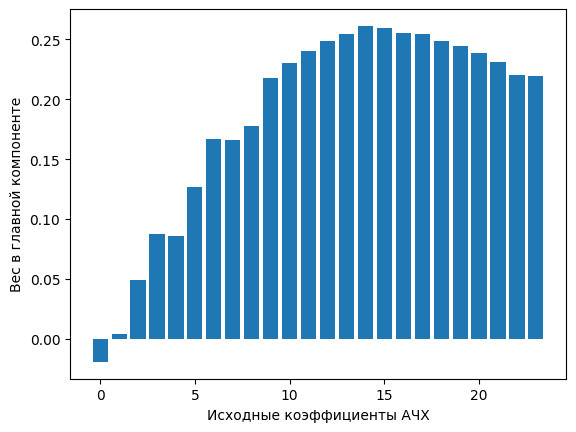

In [67]:
plt.bar(range(24), pca.components_[0])  # Важность признаков для 1-й компоненты
plt.xlabel('Исходные коэффициенты АЧХ')
plt.ylabel('Вес в главной компоненте')
plt.show()

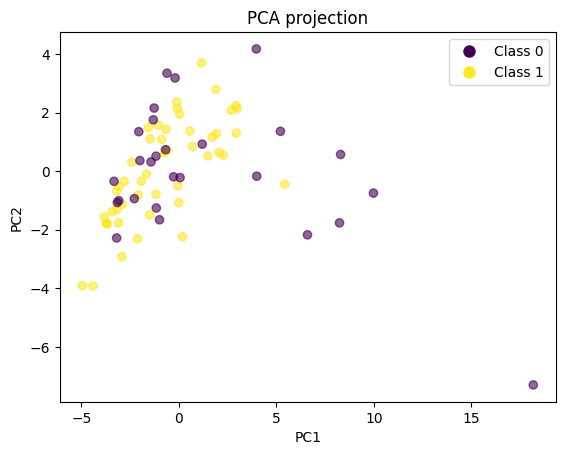

In [68]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Нормализация данных
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)

# Визуализация
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.6)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
                               markerfacecolor=plt.cm.viridis(0.), markersize=10, label='Class 0'),
                    plt.Line2D([0], [0], marker='o', color='w', 
                               markerfacecolor=plt.cm.viridis(1.), markersize=10, label='Class 1')])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA projection')
plt.show()

## Выделение главных компонент для нелинейных данных

In [406]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=4, kernel='rbf')  # Выбор ядра: 'rbf', 'poly', 'sigmoid'
X_kpca = kpca.fit_transform(X_centered)

In [407]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=4, n_neighbors=5)
X_lle = lle.fit_transform(X_centered)

In [408]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30)
X_tsne = tsne.fit_transform(X_centered)

In [409]:
from sklearn.manifold import SpectralEmbedding

se = SpectralEmbedding(n_components=4)
X_se = se.fit_transform(X_centered)

In [410]:
from sklearn.datasets import make_swiss_roll
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Оценка классификации
clf = RandomForestClassifier()
print("Accuracy KPCA:", cross_val_score(clf, X_kpca, y, cv=5).mean())
print("Accuracy Isomap:", cross_val_score(clf, X_lle, y, cv=5).mean())
print("Accuracy KPCA:", cross_val_score(clf, X_tsne, y, cv=5).mean())
print("Accuracy Isomap:", cross_val_score(clf, X_se, y, cv=5).mean())

Accuracy KPCA: 0.5333333333333334
Accuracy Isomap: 0.5733333333333334
Accuracy KPCA: 0.5333333333333334
Accuracy Isomap: 0.4666666666666667
